# **Machine Unlearning: el arte de olvidar en la era de la Inteligencia Artificial**


En este notebook se proporciona el código para evaluar los modelos de unlearning como parte del Trabajo de Fin de Grado (TFG) titulado "Machine Unlearning: el arte de olvidar en la era de la Inteligencia Artificial", realizado por Pablo Noriega Vázquez:

In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from google.colab import drive
from zipfile import ZipFile
import h5py
import pickle

### En esta celda de código se realiza el siguiente proceso:

1. **Montar Google Drive**:
   - Se conecta Google Drive en el entorno de ejecución de Google Colab. Esto permite acceder y manipular los archivos almacenados en Google Drive desde el entorno de Colab.

2. **Instalar gdown**:
   - Se instala la herramienta `gdown` para descargar archivos desde Google Drive directamente desde Colab.

3. **Descargar y descomprimir el archivo desde Google Drive**:
   - Se define el enlace del archivo en Google Drive a través de su ID.
   - Se utiliza `gdown` para descargar el archivo desde Google Drive a Colab.
   - Luego, se descomprime el archivo descargado.

4. **Eliminar el archivo .zip después de la extracción**:
   - Una vez que el archivo se ha descomprimido con éxito, se elimina el archivo `.zip` para liberar espacio en el entorno de Colab.

Este proceso permite descargar y descomprimir el archivo en el que incluimos modelos y bases de datos, almacenado en Google Drive en el entorno de ejecución de Google Colab.


In [2]:
# Montar Google Drive
drive.mount('/content/gdrive', force_remount=True)

# Descargar y descomprimir el archivo desde Google Drive
!pip install gdown

# Enlace de Google Drive
file_id = '1HtTUZnnXz5dVAPLyDo8Vhj6IyFYfxL0-'
gdown_url = f'https://drive.google.com/uc?id={file_id}'

# Descargar el archivo
!gdown $gdown_url -O data.zip

# Descomprimir el archivo
with ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()
    print('Model decompressed successfully')

# Eliminar el archivo .zip después de la extracción para liberar espacio
os.remove('data.zip')


Mounted at /content/gdrive
Downloading...
From (original): https://drive.google.com/uc?id=1HtTUZnnXz5dVAPLyDo8Vhj6IyFYfxL0-
From (redirected): https://drive.google.com/uc?id=1HtTUZnnXz5dVAPLyDo8Vhj6IyFYfxL0-&confirm=t&uuid=a9e321fa-2dbb-4e87-ba50-616a069dae35
To: /content/data.zip
100% 2.75G/2.75G [00:43<00:00, 63.2MB/s]
Model decompressed successfully


1. **Cargar los datos**: Se cargan los datos de entrenamiento, validación y prueba desde archivos `.npy` ubicados en el directorio `./NoriegaVazquezPablo_TFG_CODE/originalData`.

2. **Normalizar etiquetas**: Se normalizan las etiquetas dividiéndolas por 60. Esto se aplica a las etiquetas de entrenamiento (`Y_train`), validación (`Y_valid`) y prueba (`Y_test`).

3. **Verificar dimensiones**: Se imprimen las dimensiones de los datos cargados para asegurar que todo se ha cargado correctamente y las dimensiones son las esperadas.


# **CÁLCULO DE UTILITY**

In [3]:
# Cargar los conjuntos de datos
X_train_original = np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/originalData', 'X_train.npy'))
Y_train_original = np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/originalData', 'Y_train.npy'))
Y_train_original = Y_train_original / 60  # Normalizar etiquetas de entrenamiento

X_valid_original = np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/originalData', 'X_valid.npy'))
Y_valid_original = np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/originalData', 'Y_valid.npy'))
Y_valid_original = Y_valid_original / 60  # Normalizar etiquetas de validación

X_test_original = np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/originalData', 'X_test.npy'))
Y_test_original = np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/originalData', 'Y_test.npy'))
Y_test_original = Y_test_original / 60  # Normalizar etiquetas de prueba

# Imprimir dimensiones de los conjuntos de datos
print("Dimensiones de los conjuntos de entrenamiento:")
print("X_train:", X_train_original.shape)
print("Y_train:", Y_train_original.shape)

print("\nDimensiones de los conjuntos de validación:")
print("X_valid:", X_valid_original.shape)
print("Y_valid:", Y_valid_original.shape)

print("\nDimensiones de los conjuntos de test:")
print("X_test:", X_test_original.shape)
print("Y_test:", Y_test_original.shape)


Dimensiones de los conjuntos de entrenamiento:
X_train: (6470, 224, 224, 3)
Y_train: (6470,)

Dimensiones de los conjuntos de validación:
X_valid: (1043, 224, 224, 3)
Y_valid: (1043,)

Dimensiones de los conjuntos de test:
X_test: (1043, 224, 224, 3)
Y_test: (1043,)


# Cargar los modelos previamente entrenados

En esta celda de código se cargan los modelos previamente entrenados para su posterior evaluación:

- **originalModel**: Este modelo representa el modelo original que se utilizó en el estudio. Se carga desde el archivo `originalModel.h5` ubicado en el directorio `./NoriegaVazquezPablo_TFG_CODE/models/`.

- **retrainedModel**: Este modelo corresponde al modelo reentrenado. Se carga desde el archivo `retrainedModel.h5` ubicado en el directorio `./NoriegaVazquezPablo_TFG_CODE/models/`.

- **fine_tuning_basic**: Este modelo es el resultado de un fine-tuning básico sobre el modelo original. Se carga desde el archivo `fine-tuningBasic.h5` ubicado en el directorio `./NoriegaVazquezPablo_TFG_CODE/models/`.

- **fine_tuning_random**: Este modelo es el resultado de un fine-tuning con etiquetas aleatorias sobre el modelo original. Se carga desde el archivo `fine-tuningRandom.h5` ubicado en el directorio `./NoriegaVazquezPablo_TFG_CODE/models/`.


In [4]:
# Cargar los modelos previamente entrenados

originalModel =  tf.keras.models.load_model('./NoriegaVazquezPablo_TFG_CODE/models/originalModel.h5')

retrainedModel =  tf.keras.models.load_model('./NoriegaVazquezPablo_TFG_CODE/models/retrainedModel.h5')

fine_tuning_basic =  tf.keras.models.load_model('./NoriegaVazquezPablo_TFG_CODE/models/fine-tuningBasic.h5')

fine_tuning_random =  tf.keras.models.load_model('./NoriegaVazquezPablo_TFG_CODE/models/fine-tuningRandom.h5')

# Evaluación de los Modelos

En esta sección se realizan predicciones en el conjunto de pruebas para cada uno de los modelos y se calcula el Error Absoluto Medio (MAE) y la utilidad en comparación con el modelo reentrenado.

### Procedimiento
- Se hacen predicciones en el conjunto de pruebas utilizando el modelo original, reentrenado, fine-tuning básico y fine-tuning-random.
- Se calcula el MAE entre las predicciones y las etiquetas reales multiplicadas por 60.
- Se calcula la utilidad dividiendo el MAE del modelo reentrenado entre el MAE del modelo a evaluar.

Finalmente, se imprimen los MAE y la utilidad de cada modelo.

In [5]:
from sklearn.metrics import mean_absolute_error

# Hacer predicciones en el conjunto de pruebas y calcular el MAE para el modelo original
Y_pred_retrained = retrainedModel.predict(X_test_original) * 60
mae_retrained = mean_absolute_error(Y_test_original * 60, Y_pred_retrained)

# Hacer predicciones en el conjunto de pruebas y calcular el MAE para el modelo original
Y_pred_original = originalModel.predict(X_test_original) * 60
mae_original = mean_absolute_error(Y_test_original * 60, Y_pred_original)
utility_original = mae_retrained / mae_original

# Hacer predicciones en el conjunto de pruebas y calcular el MAE para el modelo de fine-tuning básico
Y_pred_fine_tuning_basic = fine_tuning_basic.predict(X_test_original) * 60
mae_fine_tuning_basic = mean_absolute_error(Y_test_original * 60, Y_pred_fine_tuning_basic)
utility_fine_tuning_basic = mae_retrained / mae_fine_tuning_basic

# Hacer predicciones en el conjunto de pruebas y calcular el MAE para el modelo de fine-tuning con etiquetas aleatorias
Y_pred_fine_tuning_random = fine_tuning_random.predict(X_test_original) * 60
mae_fine_tuning_random = mean_absolute_error(Y_test_original * 60, Y_pred_fine_tuning_random)
utility_fine_tuning_random = mae_retrained / mae_fine_tuning_random

# Imprimir los MAE y la utilidad de cada modelo
print("MAE del modelo original:", mae_original)
print("Utilidad del modelo original:", utility_original)
print()

print("MAE del modelo de fine-tuning básico:", mae_fine_tuning_basic)
print("Utilidad del modelo de fine-tuning básico:", utility_fine_tuning_basic)
print()

print("MAE del modelo de fine-tuning con etiquetas aleatorias:", mae_fine_tuning_random)
print("Utilidad del modelo de fine-tuning con etiquetas aleatorias:", utility_fine_tuning_random)


33/33 [==============================] - 5s 73ms/step
MAE del modelo original: 5.680921737436823
Utilidad del modelo original: 1.1385561701312572

MAE del modelo de fine-tuning básico: 5.8597914914271065
Utilidad del modelo de fine-tuning básico: 1.1038018171216932

MAE del modelo de fine-tuning con etiquetas aleatorias: 9.70709474477649
Utilidad del modelo de fine-tuning con etiquetas aleatorias: 0.6663217642613424


# Visualización de las Predicciones de los Modelos

En esta visualización se comparan las predicciones de los cuatro modelos diferentes con las edades reales en un conjunto de 50 muestras aleatorias del conjunto de pruebas.

- **Edades reales**: Representadas por puntos negros y una línea negra que conecta los puntos.
- **Predicciones del modelo original**: Representadas por puntos azules y una línea azul que conecta los puntos.
- **Predicciones del modelo reentrenado**: Representadas por puntos rojos y una línea roja que conecta los puntos.
- **Predicciones del modelo de fine-tuning básico**: Representadas por puntos verdes y una línea verde que conecta los puntos.
- **Predicciones del modelo de fine-tuning con etiquetas aleatorias**: Representadas por puntos naranjas y una línea naranja que conecta los puntos.

Cada punto en el gráfico representa una muestra del conjunto de pruebas, y la posición vertical del punto representa la edad predicha por el modelo correspondiente.

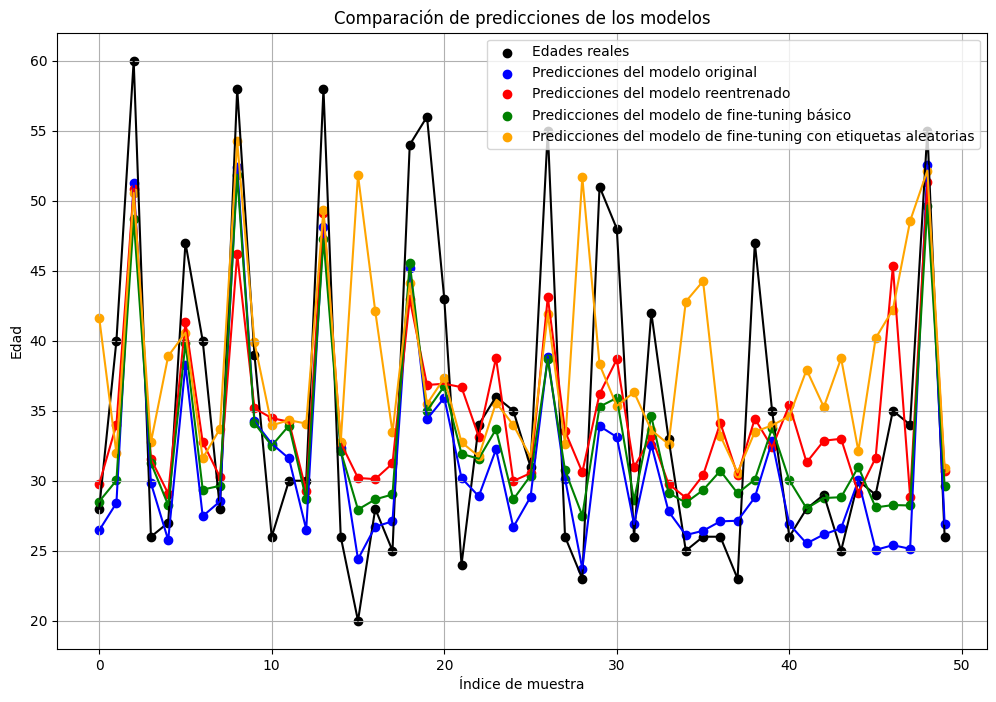

In [6]:
import matplotlib.pyplot as plt
import random

# Elegir 100 índices aleatorios del conjunto de pruebas
random_indices = random.sample(range(len(X_test_original)), 50)

# Obtener las predicciones para cada modelo en los índices seleccionados
Y_pred_original_sample = Y_pred_original[random_indices]
Y_pred_retrained_sample = Y_pred_retrained[random_indices]
Y_pred_fine_tuning_basic_sample = Y_pred_fine_tuning_basic[random_indices]
Y_pred_fine_tuning_random_sample = Y_pred_fine_tuning_random[random_indices]

# Obtener las edades reales correspondientes a los índices seleccionados
Y_test_sample = Y_test_original[random_indices] * 60

# Crear el gráfico
plt.figure(figsize=(12, 8))
plt.scatter(range(50), Y_test_sample, color='black', label='Edades reales')
plt.plot(range(50), Y_test_sample, color='black')
plt.scatter(range(50), Y_pred_original_sample, color='blue', label='Predicciones del modelo original')
plt.plot(range(50), Y_pred_original_sample, color='blue')
plt.scatter(range(50), Y_pred_retrained_sample, color='red', label='Predicciones del modelo reentrenado')
plt.plot(range(50), Y_pred_retrained_sample, color='red')
plt.scatter(range(50), Y_pred_fine_tuning_basic_sample, color='green', label='Predicciones del modelo de fine-tuning básico')
plt.plot(range(50), Y_pred_fine_tuning_basic_sample, color='green')
plt.scatter(range(50), Y_pred_fine_tuning_random_sample, color='orange', label='Predicciones del modelo de fine-tuning con etiquetas aleatorias')
plt.plot(range(50), Y_pred_fine_tuning_random_sample, color='orange')
plt.title('Comparación de predicciones de los modelos')
plt.xlabel('Índice de muestra')
plt.ylabel('Edad')
plt.legend()
plt.grid(True)
plt.show()


# **CÁLCULO DE FORGETTING**

1. **Cargar los datos**: Se cargan los datos de entrenamiento, validación y prueba desde archivos `.npy` ubicados en el directorio `./NoriegaVazquezPablo_TFG_CODE/dataWithout_20-28`.

2. **Normalizar etiquetas**: Se normalizan las etiquetas dividiéndolas por 60.

3. **Verificar dimensiones**: Se imprimen las dimensiones de los datos cargados para asegurar que todo se ha cargado correctamente y las dimensiones son las esperadas.


In [7]:
# Cargar los conjuntos de datos
X_forget = np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/dataWithout_20-28', 'X_forget_20-28.npy'))
Y_forget= np.load(os.path.join('./NoriegaVazquezPablo_TFG_CODE/dataWithout_20-28', 'Y_forget_20-28.npy'))

Y_forget = Y_forget / 60  # Normalizar etiquetas de entrenamiento

# Imprimir dimensiones de los conjuntos de datos
print("Dimensiones de los conjuntos de forget:")
print("X_train:", X_forget.shape)
print("Y_train:", Y_forget.shape)



Dimensiones de los conjuntos de forget:
X_train: (1735, 224, 224, 3)
Y_train: (1735,)


###En este bloque de código se calcula el forgetting para los tres modelos.

El forgetting se calcula como una medida de la similitud entre las predicciones de cada modelo y las edades reales en un conjunto de datos de prueba específico.

Se calcula el forgetting para los siguientes modelos:

- **Modelo Original**: Se compara la similitud entre las predicciones del modelo reentrenado y las predicciones del modelo original.
- **Modelo de Fine-Tuning Básico**: Se evalúa la similitud entre las predicciones del modelo reentrenado y las predicciones del modelo de fine-tuning básico.
- **Modelo de Fine-Tuning con Etiquetas Aleatorias**: Se determina la similitud entre las predicciones del modelo reentrenado y las predicciones del modelo de fine-tuning con etiquetas aleatorias.

Finalmente, se imprime el forgetting calculado para cada modelo.


In [8]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def compute_forgetting(Y_true, Y_pred, alpha):
    # Calcular el error absoluto
    absolute_error = np.abs(Y_true - Y_pred)

    # Calcular la similitud para cada muestra
    similarity = []
    for i in range(len(absolute_error)):
        z = (1 / (np.exp(absolute_error[i] / alpha)))
        similarity.append(z)

    # Calcular el olvido promedio
    forgetting = np.mean(similarity)

    return forgetting


Y_pred_forget_original = originalModel.predict(X_forget) * 60
Y_pred_forget_retrained= retrainedModel.predict(X_forget) * 60
Y_pred_forget_fine_tuning_basic = fine_tuning_basic.predict(X_forget) * 60
Y_pred_forget_fine_tuning_random = fine_tuning_random.predict(X_forget) * 60


e_r = np.abs(Y_forget *60 - Y_pred_forget_retrained)
e_o = np.abs(Y_forget *60 - Y_pred_forget_original)
e_u1 = np.abs(Y_forget *60 - Y_pred_forget_fine_tuning_basic)
e_u2 = np.abs(Y_forget *60 - Y_pred_forget_fine_tuning_random)



# Calcular el forgetting para el modelo original
forgetting_original = compute_forgetting(e_r, e_o, alpha=15)
print("Forgetting del modelo original:", forgetting_original)

# Calcular el forgetting para el modelo de fine-tuning básico
forgetting_fine_tuning_basic = compute_forgetting(e_r, e_u1, alpha=15)
print("Forgetting del modelo de fine-tuning básico:", forgetting_fine_tuning_basic)

# Calcular el forgetting para el modelo de fine-tuning con etiquetas aleatorias
forgetting_fine_tuning_random = compute_forgetting(e_r, e_u2, alpha=15)
print("Forgetting del modelo de fine-tuning con etiquetas aleatorias:", forgetting_fine_tuning_random)

55/55 [==============================] - 4s 70ms/step
Forgetting del modelo original: 0.7665511931076636
Forgetting del modelo de fine-tuning básico: 0.8518233383875019
Forgetting del modelo de fine-tuning con etiquetas aleatorias: 0.5952382812116971


# **CÁLCULO DE UTILITY * FORGETTING**

###En este bloque de código se calcula el Utility * Forgetting para los tres modelos.


In [9]:
# Calcular la utilidad ponderada para el modelo original
utility_forgetting_original = utility_original * forgetting_original
print("Utilidad ponderada del modelo original:", utility_forgetting_original)

# Calcular la utilidad ponderada para el modelo de fine-tuning básico
utility_forgetting_fine_tuning_basic = utility_fine_tuning_basic * forgetting_fine_tuning_basic
print("Utilidad ponderada del modelo de fine-tuning básico:", utility_forgetting_fine_tuning_basic)

# Calcular la utilidad ponderada para el modelo de fine-tuning con etiquetas aleatorias
utility_forgetting_fine_tuning_random = utility_fine_tuning_random * forgetting_fine_tuning_random
print("Utilidad ponderada del modelo de fine-tuning con etiquetas aleatorias:", utility_forgetting_fine_tuning_random)


Utilidad ponderada del modelo original: 0.8727615906342072
Utilidad ponderada del modelo de fine-tuning básico: 0.9402441487787916
Utilidad ponderada del modelo de fine-tuning con etiquetas aleatorias: 0.39662022169286704
